In [1]:
import sys
sys.path.append('..')
from utilities import formatCell, defaultPlotting
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Rectangle
from statsmodels.stats.multitest import fdrcorrection
from statsmodels.stats.multitest import multipletests

In [2]:
orderBy = 'maxRnk'
value = 'maxRnk'
alpha = 0.01

xlabels = (formatCell('GM12878'), formatCell('H1hESC'), formatCell('IMR90'))

In [3]:
LOLApaths = glob.glob('*fullVCF-LOLA-results.csv')
LOLAresultsAll = pd.concat([pd.read_csv(file) for file in LOLApaths])

LOLAresultsAll['p(adj)'] = multipletests(LOLAresultsAll['p'], method='bonferroni')[1]

# Define order by chosen rank across cell types
orderPivot = pd.pivot_table(LOLAresultsAll, index='description', columns='cellType', values=orderBy)
order = orderPivot.max(axis=1).sort_values().index

LOLAresults = (pd.pivot_table(
    LOLAresultsAll, index='description', columns='cellType', values=value)
    .reindex(order))

In [4]:
minRank = LOLAresultsAll[['rnkPV', 'rnkOR', 'rnkSup']].min().min()
maxRank = LOLAresultsAll[['rnkPV', 'rnkOR', 'rnkSup']].max().max()
midRank = (minRank + maxRank) / 2

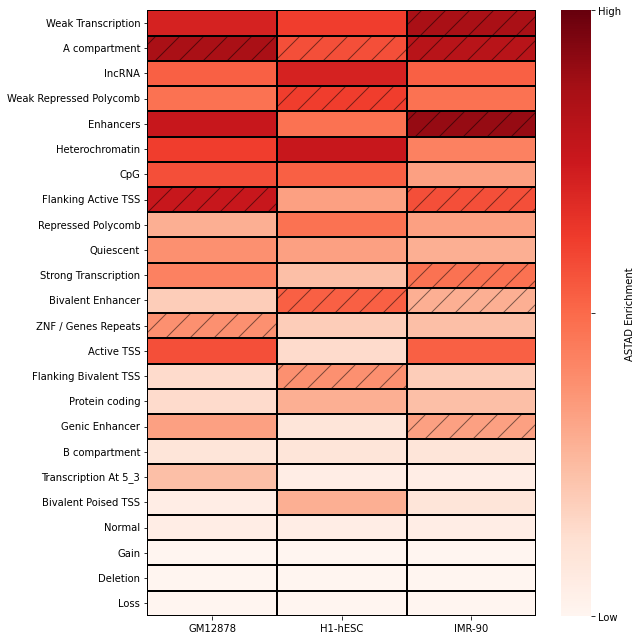

In [5]:
fig, ax = plt.subplots(figsize=(9,9))
sns.heatmap(
    data=LOLAresults, vmin=minRank, vmax=maxRank, yticklabels=1, fmt=".0f",
    linewidths=1, linecolor='black', xticklabels=xlabels,
    cmap='Reds_r', cbar_kws={'label': 'ASTAD Enrichment'}, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('')
ax.set_facecolor('grey')
cbar = ax.collections[0].colorbar
cbar.set_ticks([minRank, midRank, maxRank])
cbar.set_ticklabels(['High', '', 'Low'])
for index, row in LOLAresultsAll[LOLAresultsAll['p(adj)'] < alpha].iterrows():
    namePos = LOLAresults.index.get_loc(row['description'])
    idPos = LOLAresults.columns.get_loc(row['cellType'])
    ax.add_patch(Rectangle((idPos, namePos), 1, 1, ec='Black', alpha=0.5, fc='none', hatch='/', lw=2))

plt.gcf().axes[1].invert_yaxis()
fig.tight_layout()
fig.savefig('LOLAenrichment.svg', dpi=300)
fig.patch.set_facecolor('white')
fig.savefig('LOLAenrichment.png',  transparent=False, dpi=300)

In [6]:
LOLAsubset = LOLAresults.drop([
    'lncRNA', 'Protein coding', 'A compartment', 'B compartment', 'Gain', 'Loss', 'Deletion', 'Normal', 'CpG'])

In [7]:
labels = []
values = []
significance = {}
for x, cell in enumerate(['GM12878', 'H1hESC', 'IMR90']):
    cellIdx = LOLAresultsAll['cellType']==cell
    sort = LOLAsubset[cell].sort_values()
    labels.append(list(sort.index))
    values.append(list(sort.values))
    for y, label in enumerate(sort.index):
        labelIdx = LOLAresultsAll['description'] == label
        isSig = LOLAresultsAll.loc[cellIdx & labelIdx, 'p(adj)'].values < alpha
        significance[(x, y)] = bool(isSig)
labels = np.array(labels).T
values = np.array(values).T

In [8]:
active = ([
    'Active TSS', 'Enhancers', 'Flanking Active TSS', 'Genic Enhancer', 
    'Strong Transcription', 'Transcription At 5_3', 'Weak Transcription'
])

bivalent = ['Bivalent Enhancer', 'Bivalent Poised TSS', ' Flanking Bivalent TSS']
inactive = ([
    'Heterochromatin', 'Weak Repressed Polycomb', 'Quiescent', 'ZNF / Genes Repeats', 'Repressed Polycomb'
])

In [9]:
inactiveOnly = np.isin(labels, active + bivalent)
bivalentOnly = np.isin(labels, active + inactive)

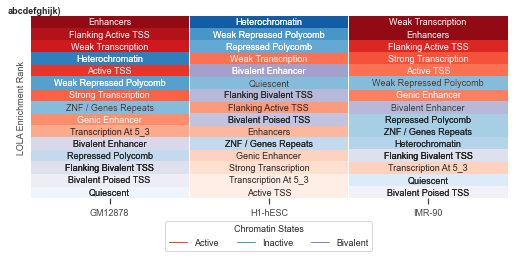

In [10]:
defaultPlotting()

fig, ax = plt.subplots()

sns.heatmap(
    data=values, annot=labels, fmt = '', cmap='Reds_r', 
    vmin=minRank, vmax=maxRank, cbar=False, ax=ax)
sns.heatmap(
    data=values, mask=inactiveOnly, annot=labels, fmt = '', cmap='Blues_r', 
    vmin=minRank, vmax=maxRank, cbar=False, ax=ax)
sns.heatmap(
    data=values, mask=bivalentOnly, annot=labels, fmt = '', cmap='Purples_r',
    xticklabels=xlabels,yticklabels=0,
    linewidths=0, linecolor='black',
    vmin=minRank, vmax=maxRank, cbar=False, ax=ax)


thickness = 1
custom_lines = [Line2D([0], [0], color=plt.cm.Reds(0.6), lw=thickness),
                Line2D([0], [0], color=plt.cm.Blues(0.6), lw=thickness),
                Line2D([0], [0], color=plt.cm.Purples(0.6), lw=thickness)]
ax.legend(
    custom_lines, ['Active', 'Inactive', 'Bivalent'],  
    loc='upper center', title='Chromatin States', ncol=3,
    bbox_to_anchor=(0.5, -0.1))

ax.set_ylabel('LOLA Enrichment Rank')

for pos in ['left', 'right', 'top', 'bottom']:
    ax.spines[pos].set_color('white')

for i in range(4):
    ax.axvline(i, color='white', lw=1)


fig.tight_layout()
ax.text(0, 1, 'abcdefghijk)', transform=fig.transFigure, verticalalignment='top', weight='bold')
fig.savefig('LOLAenrichment-chromStates-fancy.svg')